# FORESEE Models: U(1)B-L Gauge Boson

## Load Libraries 

In [1]:
import numpy as np
import sys
import os
src_path = "../../"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt

/home/makelat/work/FORESEE/Models/U(1)B-L/../../src/foresee.py:563: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def boostlist(arr_particle, arr_boost):


## 1. Specifying the Model

The phenomenology of the U(1)B-L gauge boson $A'$ can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = \frac{1}{2} \color{red}{m_{A'}}^2 X'^2  - \color{red}{g_{B-L}} \sum x_{f}\bar f \gamma^\mu f X'_\mu
\end{equation}

with the $U(1)_{B-L}$ gauge boson mass $m_{A'}$ and the coupling strength to fermion $g_{B-L}$ as free parameters.The parameters $x_{f}$ specify the baryon minus lepton number of different fermions, in this case $x_{u}$ = $x_{d}$=1/3 and $x_{e}$ = $x_{\nu}$ = -1 for all three generations.  

In [2]:
energy = "13.6"
modelname="U(1)B-L"
model = Model(modelname, path="./")

**Production:** If the U(1)B-L gauge boson is sufficiently light, it is primarily produced in the decay of pseudoscalar mesons $\pi^0, \eta \to A' \gamma$. The branching fractions can be found in Tab. 3 of [1801.04847](https://arxiv.org/pdf/1801.04847.pdf). We find

\begin{equation}
    \text{BR}(\pi^0 \to X \gamma) = 2 (g_{B-L}/e)^2 \times\text{BR}(\pi^0 \to \gamma\gamma) \times \left(1-m_{A'}^2/m_\pi^2\right)^3
    \quad\quad\text{and}\quad\quad
    \text{BR}(\eta \to X \gamma) = 0.5 (g_{B-L}/e)^2 \times\text{BR}(\eta \to \gamma\gamma) \times \left(1-m_{A'}^2/m_\eta^2\right)^3
\end{equation}


In the following, we model the production using `EPOSLHC`, `SIBYLL` and `QGSJET`. 

In [3]:
model.add_production_2bodydecay(
    pid0 = "111",
    pid1 = "22",
    br = "2*0.99 * (coupling/0.303)**2 * pow(1.-pow(mass/self.masses('pid0'),2),3)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET'],
    energy = energy,
    nsample = 100
)

In [4]:
model.add_production_2bodydecay(
    pid0 = "221",
    pid1 = "22",
    br = "2*0.25*0.39  * (coupling/0.303)**2 * pow(1.-pow(mass/self.masses('pid0'),2),3)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET'],
    energy = energy,
    nsample = 100, 
)

The $U(1)_{B-L}$ can also be produced via dark Bremsstrahlung, so coherent radiation off a proton in processes such as $p p \to p p X'$. The spectra for LLPs have been obtained following the FWW approximation described in [1708.09389](https://arxiv.org/abs/1708.09389), rescaled by ($g_{B-L}/\epsilon e)^2$ (achieved by setting the reference coupling to $g_{B-L,ref} = e$ as derived in [1803.05466](https://arxiv.org/abs/1803.05466), and are provided in the `files/direct` directory. As the FWW apprixmation loose validaty at high pT, we impose a cut on the pT of the dark photon and study the associated uncertainy by varing that cut as `0.5`, `1`, `2` GeV.

In [5]:
masses_brem = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

model.add_production_direct(
    label = "Brem",
    energy = energy,
    condition = ["p.pt<1", "p.pt<2", "p.pt<0.5"],
    coupling_ref=0.303,
    masses = masses_brem,
)

**Decay:** The $U(1)_{B-L}$ gauge boson can decay into a varity of light states. Here we use the lifetime and the decay branching fractions as presented in [1801.04847](https://arxiv.org/pdf/1801.04847.pdf) for the DarkCast tool.

In [6]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
)

decay_modes = ["e_e", "mu_mu", "nu_nu", "Hadrons"]     
model.set_br_1d(
    modes = decay_modes,
    finalstates=[[11,-11], [13,-13], [12,-12], None],
    filenames=["model/br/"+mode+".txt" for mode in decay_modes],
)

We can now initiate FORESEE with the model that we just created. 

In [7]:
foresee = Foresee(path=src_path)
foresee.set_model(model=model)

## 2. Event Generation

In the following, we want to study one specific benchmark point with $m_{A'}=30$ MeV and $\epsilon=10^{-5}$ and export events as a HEPMC file. 

In [8]:
mass, coupling, = 0.03, 1e-5

First, we will produce the corresponding flux for this mass and a reference coupling $\epsilon_{ref}=1$. 

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.03.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_0.03.npy


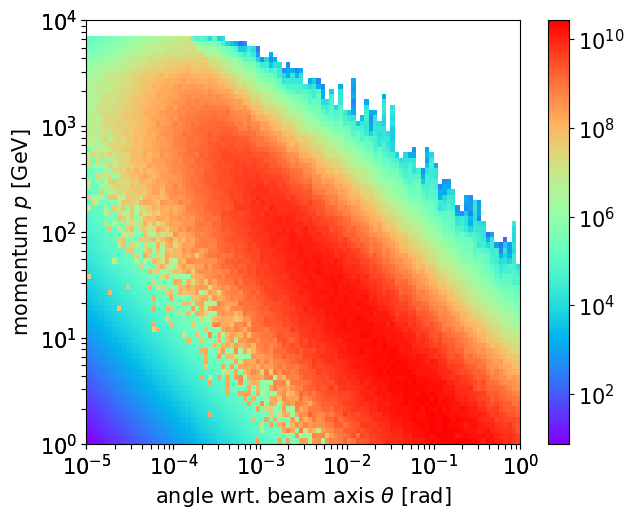

In [9]:
plot=foresee.get_llp_spectrum(mass=mass, coupling=1, do_plot=True)
plot.savefig("Spectrum_"+modelname+".pdf")
plot.show()

Next, let us define the configuration of the detector (in terms of position, size and luminosity). Here we choose FASER during 2022/2023.  Note that we explicly specify the detectable decay channels, to exclude decays into neutrinos. 

In [10]:
foresee.set_detector(
    distance=474, 
    selection="np.sqrt(x.x**2 + (x.y+0.065)**2)<.1", 
    length=1.5, 
    luminosity=60, 
    channels=["e_e"],
)

For our benchmark point, let us now look at how many particle decay inside the decay volume. We also export 1000 unweighted events as a HEPMC file. 

In [11]:
setupnames = ['EPOSLHC_pT=1', 'SIBYLL_pT=2', 'QGSJET_pT=0.5']
modes = {'111': ['EPOSLHC', 'SIBYLL', 'QGSJET'  ], 
         '221': ['EPOSLHC', 'SIBYLL', 'QGSJET'  ], 
         "Brem":["p.pt<1" , "p.pt<2", "p.pt<0.5"]}

momenta, weights, _ = foresee.write_events(
    mass = mass, 
    coupling = coupling, 
    energy = energy, 
    numberevent = 1000,
    filename = "model/events/test.hepmc", 
    return_data = True,
    weightnames=setupnames,
    modes=modes,
)

for isetup, setup in enumerate(setupnames):
    print("Expected number of events for "+setup+":", round(sum(weights[:,isetup]),3))

Expected number of events for EPOSLHC_pT=1: 3.27
Expected number of events for SIBYLL_pT=2: 4.218
Expected number of events for QGSJET_pT=0.5: 2.114


Let us plot the resulting energy distribution

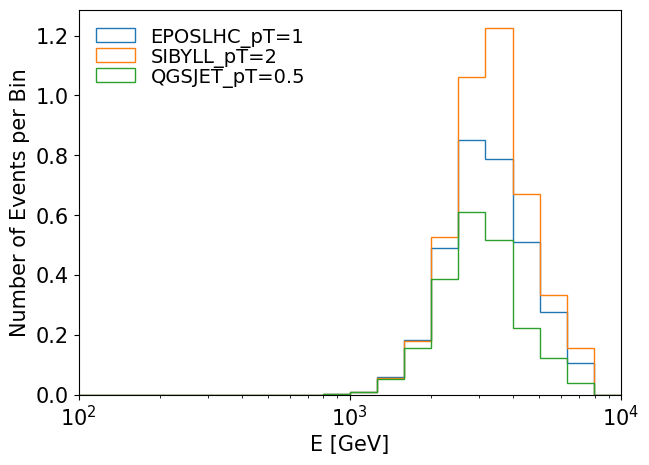

In [12]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
energies = [p.e for p in momenta], 
for isetup, setup in enumerate(setupnames):
    ax.hist(energies, weights=weights[:,isetup], bins=np.logspace(2,4, 20+1), histtype='step', label=setup) 
ax.set_xscale("log")
ax.set_xlim(1e2,1e4) 
ax.set_xlabel("E [GeV]") 
ax.set_ylabel("Number of Events per Bin") 
ax.legend(frameon=False, labelspacing=0, fontsize=14, loc='upper left')
plt.savefig("E_distribution_"+modelname+".pdf")
plt.show()

## 3. Sensitivity Reach

In the following, we will obtain the projected sensitivity for the LLP model. For this, we first define a grid of couplings and masses, and then produce the corresponding fluxes. 

In [13]:
masses=[round(x,5) for x in np.logspace(-2,0.2,22+1)]
couplings = np.logspace(-8,-3,101) 

for mass in masses: foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.01259.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.01259.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.01259.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.01259.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.01259.npy
save data 

save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_

We can now plot the `production rate vs mass` using the `foresee.plot_production()` function.

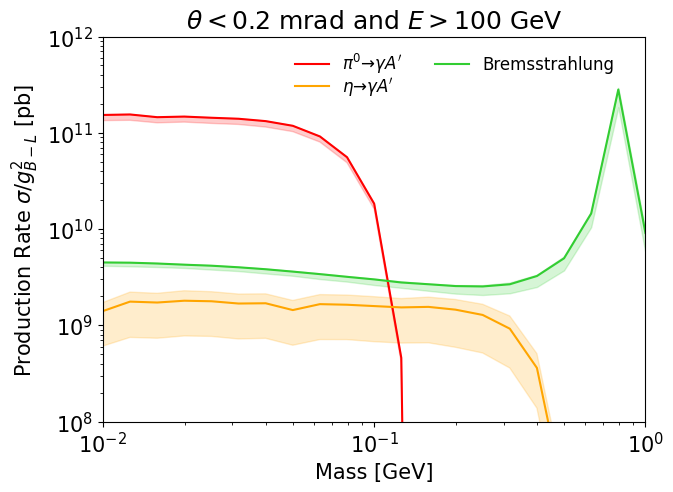

In [14]:
productions=[
    {"channels": ["111"] , "color": "red"      , "label": r"$\pi^0 \to \gamma A'$", "generators": ["EPOSLHC","QGSJET","SIBYLL"]   },
    {"channels": ["221"] , "color": "orange"   , "label": r"$\eta \to \gamma A'$" , "generators": ["EPOSLHC","QGSJET","SIBYLL"]   },
    {"channels": ["Brem"], "color": "limegreen", "label": r"Bremsstrahlung"       , "generators": ["p.pt<1", "p.pt<2", "p.pt<0.5"]},
]

plot=foresee.plot_production(
    masses = masses,
    productions = productions,
    energy=energy,
    condition="logth<-3.7 and logp>2",  
    xlims=[0.01,1],ylims=[1e8,1e12],
    xlabel=r"Mass [GeV]",
    ylabel=r"Production Rate $\sigma/g_{B-L}^2$ [pb]",
    title=r"$\theta < 0.2$ mrad and $E > 100$ GeV",
    legendloc=(0.97,1),
    fs_label=12,
    ncol=2,
)
plot.savefig("Production_"+modelname+".pdf")

Let us now scan over various masses and couplings, and record the resulting number of evets. Note that here we again consider the FASER configuration, which we set up before.

In [15]:
#get reach  
list_nevents = {label:[] for label in setupnames}
for mass in masses:
    couplings, _, nevents, _, _  = foresee.get_events(mass=mass, energy=energy, couplings = couplings,modes=modes)
    for i,label in enumerate(setupnames): list_nevents[label].append(nevents.T[i])  
        
#save results
configuration='default'
for label in setupnames: 
    result = np.array([masses,couplings,list_nevents[label]], dtype='object')
    np.save("model/results/"+energy+"TeV_"+configuration+"_"+label+".npy",result)

We can now plot the results. For this, we first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [16]:
setups = [ 
    ["13.6TeV_default_EPOSLHC_pT=1.npy",  "EPOS / pT=1"    , "red"        ,  "solid"  , 0., 3],
    ["13.6TeV_default_SIBYLL_pT=2.npy" ,  "SYBILL / pT=2"  , "magenta"    ,  "solid"  , 0., 3],
    ["13.6TeV_default_QGSJET_pT=0.5.npy" ,"QGSJET / pT=0.5", "orange"     ,  "solid"  , 0., 3],
]

Then we specify all the existing bounds, separating the bounds obtained by experimental collaboratios and theory recasts. **ADD FASER** **Separate bounds obtained by experiment/theory recast**

In [17]:
bounds = [ 
    ["bounds_NA64_inv_new.txt", "NA64 inv.",7.6e-2, 5.0e-5, 0],
    ["bounds_CHARM-II.txt",     "Charm II" ,1.2e-1, 1.3e-4, 20],
    #["bounds_NA64_inv.txt",     "NA64 inv.",5.6e-2, 5.0e-5, 0],
    ["bounds_Texono.txt",       "Texono"   ,5.0e-2, 1.2e-4, 0],
    
    ["bounds_LHCb_prompt.txt",  "LHCb"     ,2.3e-1, 8.0e-5, 0],
    ["bounds_BaBar.txt",        "BaBar"    ,3.0e-1, 4.0e-4, 0],
    ["bounds_NA48.txt",         "NA48"     ,2.5e-2, 7.0e-4, 0],
    ["bounds_KLOE_combined.txt","KLOE"     ,5.4e-1, 7.0e-4, 0], 
    ["bounds_A1.txt",           "A1"       ,1.2e-1, 6.5e-4, 0], 
    
    #["bounds_E137.txt",         "E137"     ,1.5e-1, 5.0e-8, 0],
    ["bounds_NuCal.txt",        "NuCal"    ,2.0e-1, 2.2e-7, 0],
    ["bounds_Orsay.txt",        "Orsay"    ,2.5e-2, 3.3e-6, 0],
    ["bounds_CHARM.txt",        "Charm"    ,1.2e-1, 1.0e-7, 0],
    ["bounds_E141.txt",         "E141"     ,1.1e-2, 9.3e-6, 0],    
    ["bounds_NA64.txt",         "NA64 ee"  ,1.5e-2, 1.2e-4, 0],   
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [18]:
projections = [
    ["limits_SHIP.txt",       "blue",  " SHiP"       , 0.6e+0, 3.0e-7, 0],
    ["limits_Belle-IIyvv.txt","violet","Belle-II inv", 0.4e+0, 1.5e-5, 0],
    ["limits_NA_64mu.txt",    "brown", "NA64$\mu$"   , 0.4e+0, 4.0e-5, 0],
    ["limits_Belle_II.txt",   "navy",  "Belle-II"    , 4.0e-1, 7.0e-5, 0],
]

We also want to show the branching fractions for some of the channels (name of file in model/br directory, color, line style, label, x-position, y-position)  

In [19]:
branchings = [
    ["e_e"     , "red"          , "solid" , r"ee"         , 0.050, 0.20],
    ["mu_mu"   , "orange"       , "solid" , r"$\mu\mu$"   , 0.170, 0.10],
    ["nu_nu"   , "black"        , "dashed", r"$\nu\nu$"   , 0.110, 0.70],
    ["Hadrons" , "blue"         , "solid" , r"hadrons"    , 0.410, 0.02],
]

Finally, we can plot everything using `foresee.plot_reach()`. Here we also add the dark matter relict target line obtained in [2105.07077](https://arxiv.org/abs/2105.07077).

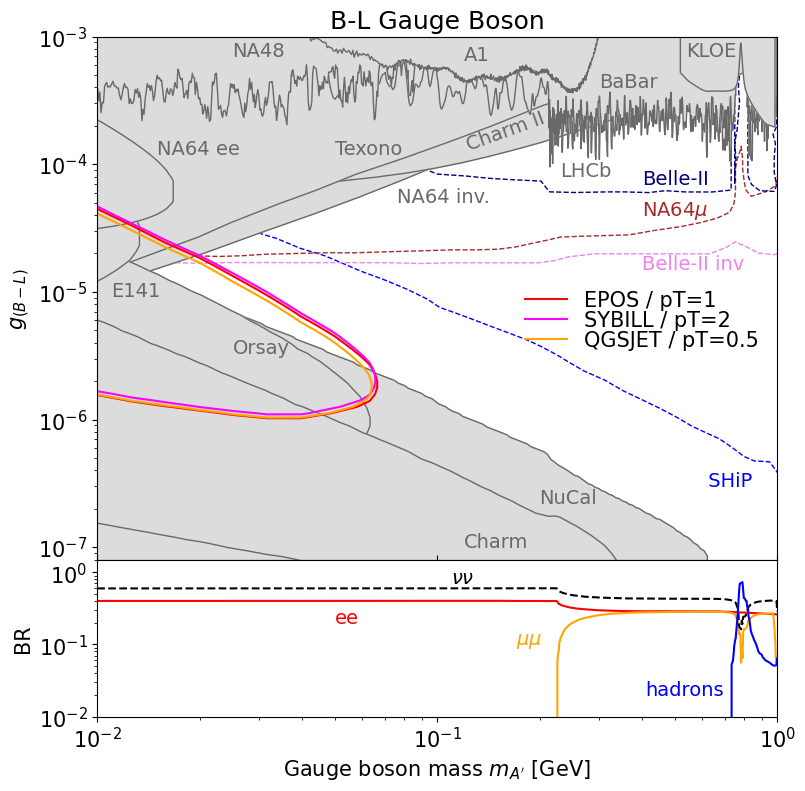

In [20]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title = "B-L Gauge Boson", 
    xlims = [0.01,1], 
    ylims = [8e-8,1e-3],
    xlabel=r"Gauge boson mass $m_{A'}$ [GeV]", 
    ylabel=r"$g_{(B-L)}$" ,
    legendloc=(1.00,0.550),
    branchings=branchings,
    figsize=(8,8),
)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("Reach_"+modelname+".pdf")
plot.show()